In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
data = pd.read_csv('SPY.csv', index_col=0)
data.describe()

,Open,High,Low,Close,Adj Close,Volume,adj_factor,Adj Open,Adj High,Adj Low,Amount,Return
count,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4.940000e+03,4940.000000,4940.000000,4940.000000,4940.000000,4.940000e+03,4939.000000
mean,154.916778,155.806689,153.932967,154.915397,130.080000,1.131555e+08,0.812321,130.078555,130.806185,129.273872,1.670164e+10,0.000215
std,55.392654,55.455574,55.300664,55.399593,61.369875,9.924321e+07,0.090854,61.360605,61.498516,61.191653,1.263130e+10,0.012023
min,67.949997,70.000000,67.099998,68.110001,53.947025,1.436600e+06,0.680423,53.820293,55.444013,53.147048,2.102599e+08,-0.103637
25%,115.087498,115.914999,114.237499,115.035000,86.590834,4.774008e+07,0.729271,86.563831,87.135411,85.990860,5.662622e+09,-0.004688
50%,135.365005,136.359375,134.345001,135.367500,104.276886,8.471245e+07,0.806054,104.382847,105.009414,103.567459,1.585927e+10,0.000637
75%,194.987495,195.797501,193.922504,194.922497,174.989334,1.524191e+08,0.892026,174.750644,175.675158,173.599633,2.352806e+10,0.005786
max,301.880005,302.230011,300.850006,302.010010,296.099121,8.710263e+08,0.980428,295.971668,296.314816,294.961829,9.561302e+10,0.135577


In [4]:
def series_to_supervised(data, lags=10, columns=None, burnout=100):
    """
    Create  X: a 3D array, in shape (nsample, lags, nfeatures)
            Y: a 2D array, in shape (nsample, 1)
    """
    if not columns:
        columns = ['Adj Open', 'Adj High', 'Adj Low', 'Adj Close', 'Amount']
    nsample, nfeatures = len(data), len(columns)
    
    Y = data['Return'].values
    X = np.zeros((nsample, lags, nfeatures))
    for i in range(1, lags+1):
        X[:, lags-i, :] = data[columns].shift(i).values
    
    return X[lags+burnout:], Y[lags+burnout:]

def normalize_X(X, data, lags=10, burnout=100, window=50):
    """
    This part will normalize features in X.
    To normalize the prices, we will calculate the ratio of price to the close of lag+1 day before
    To normalize the amount, we will calculate the ratio of amount to its 50 days' rolling average
    args:
        X: feature data
        data: the price&volume dataframe
        window: the window for the rolling average
    return:
        normalized X
    """
    price_o = data['Adj Close'].shift(lags + 1).values[lags+burnout:].reshape(-1, 1, 1)
    avg_amt = data['Amount'].rolling(window).mean().shift(1).values[lags+burnout:].reshape(-1, 1)
    
    X[:, :, :-1] = X[:, :, :-1] / price_o # normalize the prices
    X[:, :, -1] = X[:, :, -1] / avg_amt # normalize the amount
    
    return X

def normalize_y(Y):
    """
    Apply robust scaler to Y and Clip the extremums of Y.
    return:
        y: normalized version
        scaler: the RobustScaler
    """
    Y = Y.reshape(-1,1)
    scaler = RobustScaler()
    y = scaler.fit_transform(Y).ravel()
    y[y > 3] = 3
    y[y < -3] = -3
    return y, scaler

def Prepare_data(data, lags=10, columns=None, burnout=100, window=50):
    """
    A wrapper for data preparation.
    """
    X, Y = series_to_supervised(data, lags, columns, burnout)
    X = normalize_X(X, data, lags, burnout, window)
    y, scaler = normalize_y(Y)
    cache = {
        'X': X,
        'y': y,
        'scaler': scaler
    }
    return cache

In [5]:
cache = Prepare_data(data)

In [6]:
def build_model(units=10, dense1=10, dense2=5):
    model = keras.Sequential([
        layers.LSTM(units=units, input_shape=(10, 5)),
#         layers.GRU(units=units),
        layers.Dense(dense1, activation=tf.nn.relu),
        layers.Dense(dense2, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [7]:
model = build_model()

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                640       
_________________________________________________________________
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 811
Trainable params: 811
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X = cache['X']
y = cache['y']

# class PrintDot(keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs):
#     if epoch % 100 == 0: print('')
#     print('.', end='')

EPOCHS = 50

train_set = X[:1000]
train_label = y[:1000]

history = model.fit(
    train_set, train_label, epochs=EPOCHS, validation_split = 0.2, verbose=1)#, callbacks=[PrintDot()])

Epoch 1/50


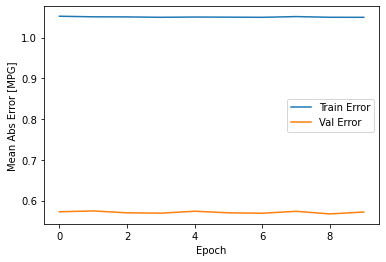

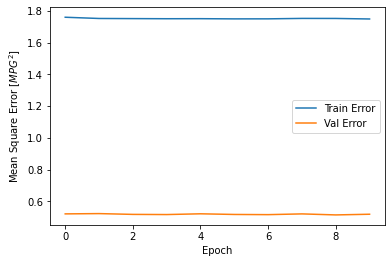

In [13]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0,])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

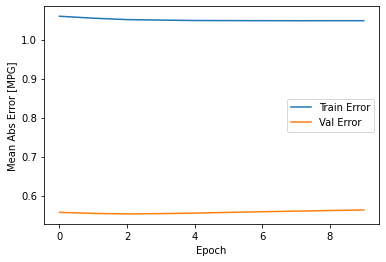

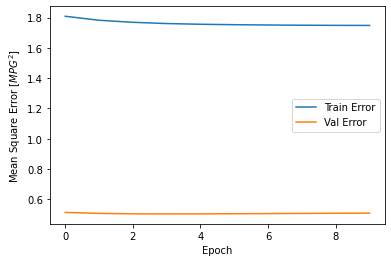

In [15]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_set, train_label, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop])

plot_history(history)